In [1]:
#diff_equations.py
import torch
import numpy as np


def grad(outputs, inputs):
    """Computes the partial derivative of
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )


def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)
    return T

In [3]:
#network.py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def np_to_th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)

##below
class Net(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=1e-3,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        self.layers = nn.Sequential( #Q: Layers is not a variable? self.layers is a function?
            nn.Linear(input_dim, self.n_units), #the linear transform part https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
            nn.Tanh(), #the activation func #I changed to tanh for fun
            nn.Linear(self.n_units, self.n_units),
            nn.Tanh(),
            nn.Linear(self.n_units, self.n_units),
            nn.Tanh(),
            nn.Linear(self.n_units, self.n_units),
            nn.Tanh(),
        )
        self.out = nn.Linear(self.n_units, output_dim) #the final transform

    def forward(self, x):
        h = self.layers(x) #it gives you the input as transformed by the hidden layers of the neural networks
        out = self.out(h) #prints out the final product. 'out' is an object, ie vector or a matrix / tensor?

        return out


    def fit(self, X, y): #the training process?
        Xt = np_to_th(X) #Xt and Yt gives you the time derivative
        yt = np_to_th(y)


        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        #losses = []  just for visualization later
        for ep in range(self.epochs): #always predefine epochs??
            optimiser.zero_grad() #WHAT DOES THIS MEAN?
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2: #meaning if this is definied
                loss += self.loss2_weight + self.loss2_weight * self.loss2(self)#Q: WHY DO YOU ADD A SELF?? #And is the first thing redundant?
            loss.backward() #?? what does the backward do?
            optimiser.step()
            #losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        return losses

    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()



class NetDiscovery(Net):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=0.001,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__(
            input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight
        )

        self.r = nn.Parameter(data=torch.tensor([0.]))

In [ ]:
#temperature prediction
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from network import Net, NetDiscovery
from diff_equations import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

#equation and training data
np.random.seed(10)

Tenv = 25
T0 = 100
R = 0.005
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

#Vanilla network
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)

plt.plot(losses)
plt.yscale('log')

#PINN
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT

    return torch.mean(pde**2)

#loss visualization
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')

#fit visualization
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

#physics loss discovery
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = model.r * (Tenv - temps) - dT

    return torch.mean(pde**2)


////divider

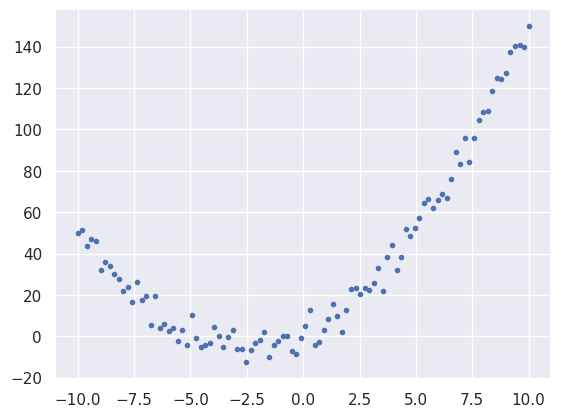

In [ ]:
#regularization example (not using NN, so we'll put it at the end)
import numpy as np
from sklearn import linear_model, preprocessing, pipeline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
def create_data(n_points):
    x = np.linspace(-10, 10, n_points)
    y = x**2 + 5*x + 1 + 5* np.random.randn(n_points)
    return x, y
x, y = create_data(100)
plt.plot(x,y, '.')



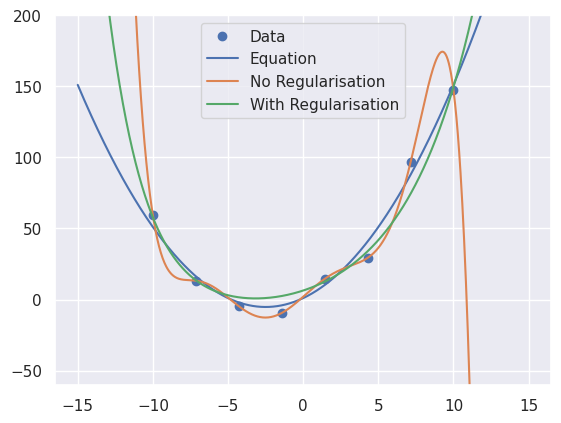

In [ ]:
#https://saturncloud.io/blog/understanding-the-differences-between-numpy-reshape1-1-and-reshape1-1/
##"The -1 is a placeholder that means “adjust this dimension to make the data fit”."
#Reshape(-1, 1) When you use reshape(-1, 1), you are asking numpy to reshape your array with 1 column and as many rows as necessary to accommodate the data. This operation will result in a 2D array with a shape (n, 1), where n is the number of elements in your original array.

np.random.seed(1)
# Create models
model = pipeline.Pipeline([
    ('poly', preprocessing.PolynomialFeatures(degree=8)),
    ('scaler', preprocessing.StandardScaler()),
    ('model', linear_model.LinearRegression())
    ])
model_l2 = pipeline.Pipeline([
    ('poly', preprocessing.PolynomialFeatures(degree=8)),
    ('scaler', preprocessing.StandardScaler()),
    ('model', linear_model.Ridge(alpha=1))
    ])
#linear regression ridge: I looked @ documentation
#correct with a lambda "loss" factor --> quantifies how 'far' away from true estimate


x, y = create_data(8)

model.fit(x.reshape(-1,1), y.reshape(-1,1))
model_l2.fit(x.reshape(-1,1), y.reshape(-1,1))

# Create test data
x_pred = np.linspace(-15, 15, 1000).reshape(-1, 1)

y_pred = model.predict(x_pred)
y_pred_l2 = model_l2.predict(x_pred)

plt.plot(x,y, 'o', label='Data')
plt.plot(x_pred, x_pred**2 + 5*x_pred + 1, label='Equation', color='b')
plt.plot(x_pred, y_pred, label='No Regularisation')
plt.plot(x_pred, y_pred_l2, label='With Regularisation')
plt.ylim(-60, 200)
plt.legend()
